# Project Title

*Unit 7 Project*

In [3]:
!pip install bambi
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.1/517.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 18.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [4]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb
import pymc as pm
import preliz as pz

In [5]:
url = "https://raw.githubusercontent.com/blortle-dev/data-science-lasa/refs/heads/main/resources/lap_times.csv"
data = pd.read_csv(url)

## Testing

Just a spot for me to test different models and ideas.

In [6]:
data = data[data["raceId"] == 1116]
data

,raceId,driverId,lap,position,time,milliseconds
557007,1116,846,1,1,1:41.712,101712
557008,1116,846,2,1,1:41.982,101982
557009,1116,846,3,1,1:42.280,102280
557010,1116,846,4,1,1:42.331,102331
557011,1116,846,5,1,1:42.244,102244
...,...,...,...,...,...,...
558016,1116,844,52,5,1:42.190,102190
558017,1116,844,53,6,1:42.656,102656
558018,1116,844,54,6,1:41.882,101882
558019,1116,844,55,6,1:42.519,102519


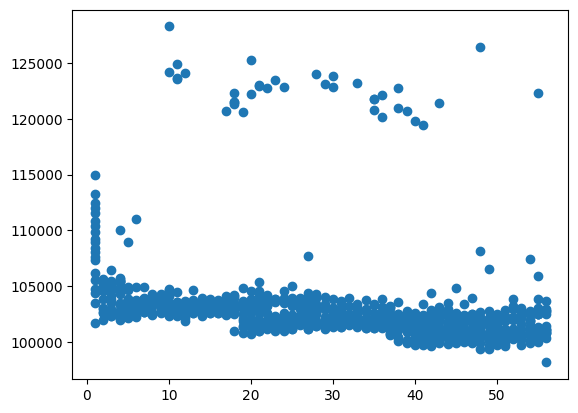

In [16]:
plt.scatter(x=data["lap"], y=data["milliseconds"])

In [9]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [38]:
ms = data["milliseconds"].values
lap = data["lap"].values[:,None]

In [39]:
with pm.Model() as model_hsgp:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(lap))

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=lap)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=ms)

    idata_hsgp = pm.sample()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d58dcc52a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.

Output()

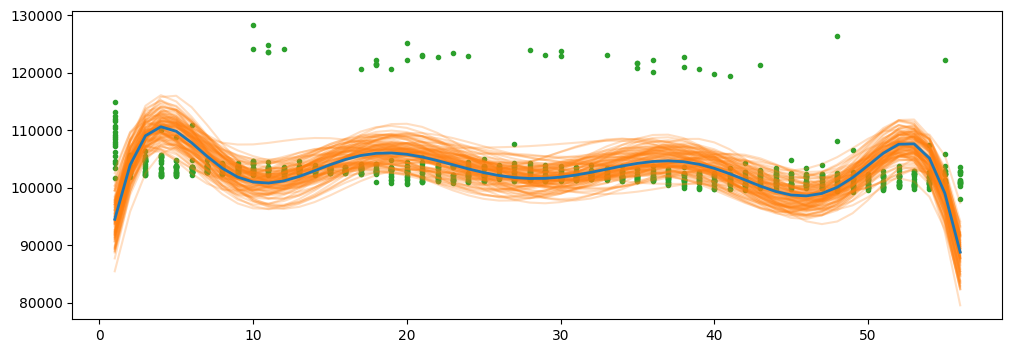

In [41]:
flat_lap = data["lap"].values.flatten()

#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(flat_lap, ms, "C2.")

#grab posterior
f = az.extract(idata_hsgp, group="posterior", var_names="f")

idx = np.argsort(flat_lap)
#plot samples of the posterior
ax.plot(flat_lap[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")

#plot posterior mean
ax.plot(flat_lap[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)


In [27]:
model_hsb = bmb.Model("milliseconds ~ 0 + hsgp(lap, m=10, c=1.5)", data, family="negativebinomial")
idata_hsb = model_hsb.fit()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d58d9c7eac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.

Output()

ERROR:pymc.stats.convergence:There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


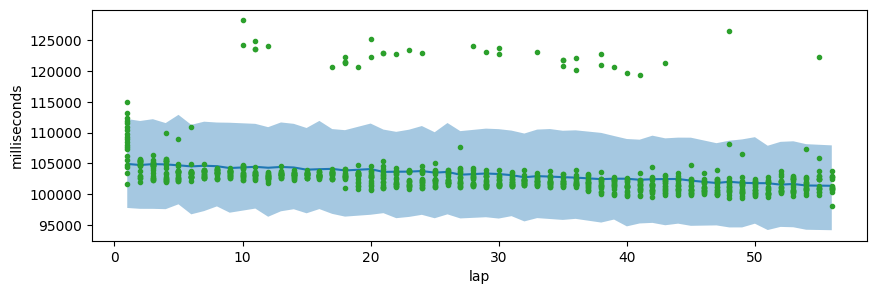

In [28]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["lap"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(data["lap"].values, data["milliseconds"].values, "C2.")